<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/knowledge/AI/notebooks/Animal_faces_latent_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal faces interpolation

an example notebook to try to interpolate between two insects in latent space.

Based on [Noufals blog](https://medium.com/@noufalsamsudin/latent-space-interpolation-of-images-using-keras-and-tensorflow-js-7e35bec01c5a) & [classification code on Kaggle](https://www.kaggle.com/code/vencerlanz09/insect-classification-using-cnn-mobilenetv2)


In [1]:
!nvidia-smi

Fri Aug 26 08:17:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [32]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dense, Dropout, Conv2DTranspose

In [4]:
# System libraries
from pathlib import Path
import os.path

In [5]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [6]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## linking GDrive to save models

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
from datetime import date
model_save_name = date.today()
model_path = "/content/gdrive/MyDrive/AI/latent_interpolation/{}".format(model_save_name) 

## downloading the Kaggle dataset

Make sure you upload your Kaggle API key JSON file here. (via Kaggle, profile, Account)

Via [link](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

In [9]:
dataset_name = "andrewmvd/animal-faces"
dataset = "animal-faces"

In [10]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download {dataset_name}
!unzip {dataset}.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

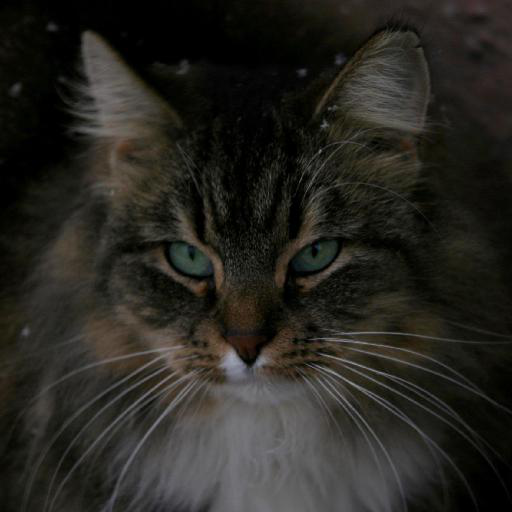

In [11]:
test_img = keras.utils.load_img('/content/afhq/train/cat/flickr_cat_000002.jpg')
test_img

Found 14630 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


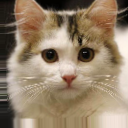

In [63]:
# hyperparameters
BATCH_SIZE = 64
img_height = 512
img_width = 512
img_dir = '/content/afhq/'
resize_factor = 4
SHAPE=(int(img_height/resize_factor),int(img_width/resize_factor))
EPOCHS=64
# Load the data
ds = keras.utils.image_dataset_from_directory(
    '/content/afhq/train',
    # labels="None", 
    label_mode=None,
    batch_size=BATCH_SIZE, 
    image_size=SHAPE
    )
print(type(ds))

## Not sure what's the best approach to loading data, with ds I can't compare images against itself, only against label??

image_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    vertical_flip=True,
    rotation_range=10,
    # zoom_range=10.0,
    width_shift_range=0.2,
    height_shift_range=0.2,

    )
train_gen = image_generator.flow_from_directory(
    os.path.join(img_dir, "train"), 
    class_mode="input", target_size=SHAPE, batch_size=BATCH_SIZE,
)
val_gen = image_generator.flow_from_directory(
    os.path.join(img_dir, "val"), 
    class_mode="input", target_size=SHAPE, batch_size=BATCH_SIZE,
)
for image, label in train_gen:
  img = keras.preprocessing.image.array_to_img(image[0])
  break
img

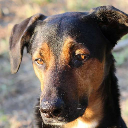

In [62]:
# show the first example of the batch
it = iter(ds)
test_img_batch = next(it)
test_img = test_img_batch[0]
# test_img_label = test_img_batch[1][0]
# print(ds.class_names[test_img_label.numpy()])
test_img = keras.preprocessing.image.array_to_img(test_img)
test_img

In [25]:
for image_batch in ds:
  print(image_batch.shape)
  print(image_batch.shape[1:])

  # print(labels_batch.shape)
  break

(64, 128, 128, 3)
(128, 128, 3)


In [64]:
# auto-encoder model
input=Input(shape=image_batch.shape[1:])
encoded=Conv2D(512, (3, 3), activation='relu', padding='same', strides=2)(input)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(encoded)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(encoded)
encoded=Flatten()(encoded)

decoded=Reshape((int(64/resize_factor),int(64/resize_factor),-1))(encoded)#(32, 32, 32))(encoded)
# decoded=Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(decoded)
# decoded=UpSampling2D((2, 2))(decoded)
# decoded=Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(decoded)
# decoded=UpSampling2D((2, 2))(decoded)
# decoded=Conv2D(512, (3, 3), activation='relu', padding='same', strides=2)(decoded)
# decoded=UpSampling2D((2, 2))(decoded)
decoded = Conv2DTranspose(64, kernel_size=3,strides=2, activation='relu',padding='same')(decoded)
decoded = Conv2DTranspose(128, kernel_size=3,strides=2, activation='relu',padding='same')(decoded)
decoded = Conv2DTranspose(512, kernel_size=3,strides=2, activation='relu',padding='same')(decoded)
decoded=Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
        
autoencoder=Model(input,decoded)
#TODO: decoder has wrong shape at the end?
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 512)       14336     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)       589952    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 4, 4, 64)          737

In [65]:
#compile the model
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=6)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Accuracy()])

In [66]:
hist = autoencoder.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callback])

Epoch 1/64
229/229 [==============================] - 115s 500ms/step - loss: 0.6504 - accuracy: 6.8141e-08 - val_loss: 0.6330 - val_accuracy: 9.4944e-08
Epoch 2/64
229/229 [==============================] - 114s 496ms/step - loss: 0.6300 - accuracy: 1.0291e-07 - val_loss: 0.6264 - val_accuracy: 5.4253e-08
Epoch 3/64
229/229 [==============================] - 114s 497ms/step - loss: 0.6254 - accuracy: 9.5954e-08 - val_loss: 0.6228 - val_accuracy: 1.4920e-07
Epoch 4/64
229/229 [==============================] - 114s 495ms/step - loss: 0.6233 - accuracy: 1.2655e-07 - val_loss: 0.6216 - val_accuracy: 9.4944e-08
Epoch 5/64
229/229 [==============================] - 115s 500ms/step - loss: 0.6218 - accuracy: 9.8735e-08 - val_loss: 0.6220 - val_accuracy: 1.3563e-07
Epoch 6/64
229/229 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 1.0569e-07

KeyboardInterrupt: ignored

In [39]:
autoencoder.save(os.path.join(model_path,"autoencoder"))

# load the model

In [ ]:
gdrive_origin = Path("/content/gdrive/MyDrive/AI/latent_interpolation")
model_list = list()
for i in os.listdir(gdrive_origin):
  print("folder found: {}".format(i))
  model_list.append(i)

In [ ]:
autoencoder = keras.models.load_model(os.path.join(gdrive_origin,model_list[0],"autoencoder"))

In [67]:
encoder = Model(inputs=autoencoder.input, outputs = autoencoder.layers[6].output)
encoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_57 (Conv2D)          (None, 64, 64, 512)       14336     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 512)      0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)       589952    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 4, 4, 64)          737

In [68]:
encoded_input = Input(shape=(1024,))

# deco = autoencoder.layers[-8](encoded_input)
# deco = autoencoder.layers[-7](deco)
# deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](encoded_input)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
decoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1024)]            0         
                                                                 
 reshape_10 (Reshape)        (None, 16, 16, 4)         0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 32, 32, 64)       2368      
 Transpose)                                                      
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 64, 64, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 128, 128, 512)    590336    
 Transpose)                                                      
                                                          

In [ ]:
len(autoencoder.layers),len(encoder.layers),len(decoder.layers)

(15, 7, 9)

# try out basic inference

In [69]:
predict_res = autoencoder.predict(val_gen)

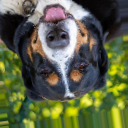

In [70]:
for image in predict_res:
  pred_img = keras.preprocessing.image.array_to_img(image)
  break
# 2. pick an image from val_gen
for image, label in val_gen:
  inf_img = keras.preprocessing.image.array_to_img(image[0])
  break
inf_img

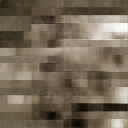

In [71]:
pred_img

## interpolation

In [72]:
# Randomly pick two images and generate their encodings
import random
test_image1 = val_gen[0][0][random.randint(0,63)].reshape(1,int(img_height/resize_factor), int(img_width/resize_factor), 3)
test_image2 = val_gen[0][0][random.randint(0,63)].reshape(1,int(img_height/resize_factor), int(img_width/resize_factor), 3)


In [73]:
#predict encodings
encoded_img1 = encoder.predict(test_image1)
encoded_img2 = encoder.predict(test_image2)

In [74]:
# interpolation
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

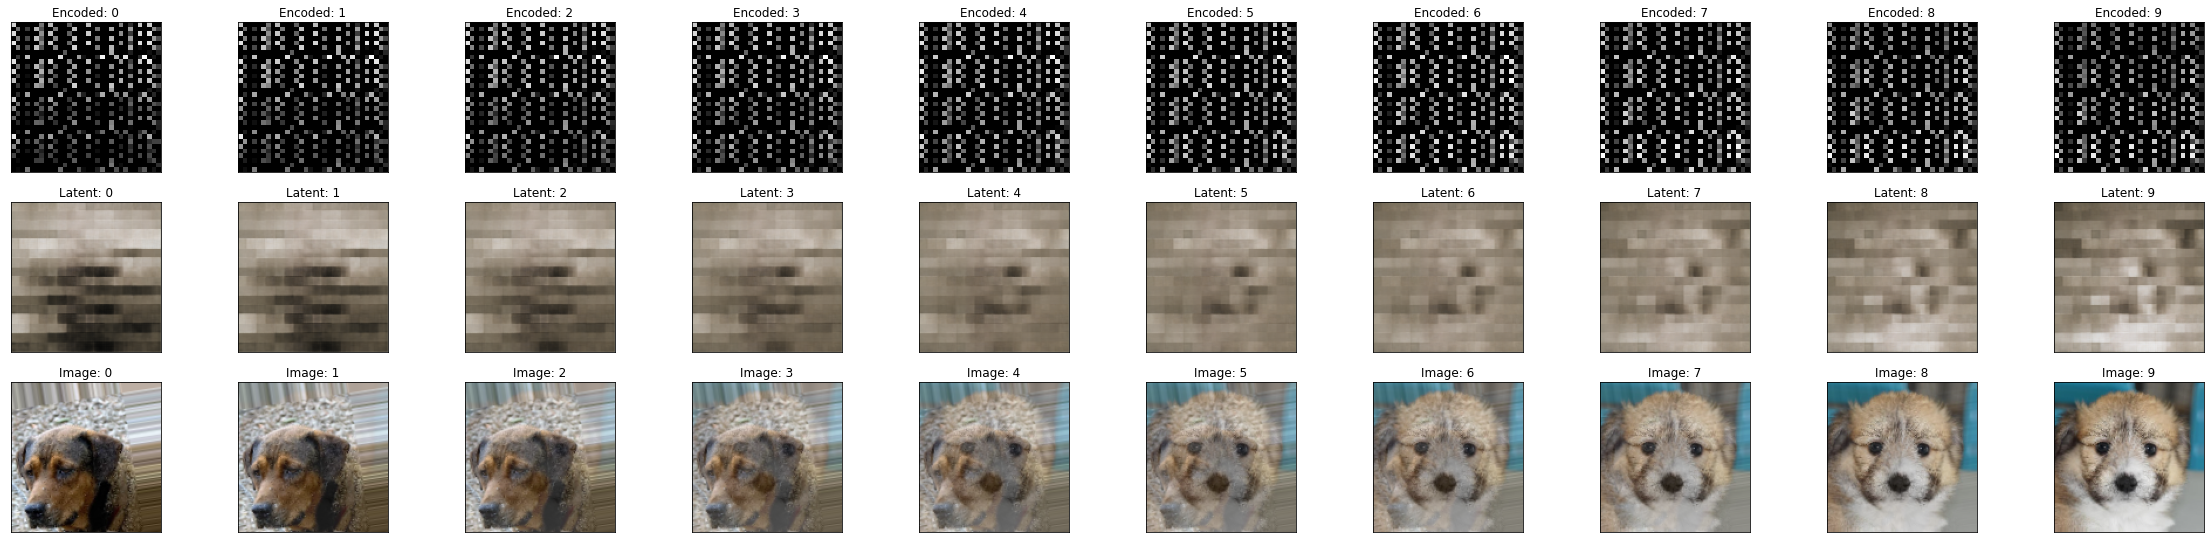

In [76]:
interpolated_images=interpolate_points(encoded_img1.flatten(),encoded_img2.flatten())
interpolated_orig_images=interpolate_points(test_image1.flatten(),test_image2.flatten())

interpolated_images.shape
num_images = 10
np.random.seed(42)
plt.figure(figsize=(40, 16))

for i, image_idx in enumerate(interpolated_images):
    
    ax = plt.subplot(5, num_images, i + 1)
    plt.imshow(interpolated_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Encoded: {}".format(i))
    
    ax = plt.subplot(5, num_images,num_images+ i + 1)
    plt.imshow(decoder.predict(interpolated_images[i].reshape(1,1024)).reshape(128,128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Latent: {}".format(i))
    
    ax = plt.subplot(5, num_images,2*num_images+ i + 1)
    plt.imshow(interpolated_orig_images[i].reshape(128,128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Image: {}".format(i))

plt.show()